## Assignment 3 Google Stock Price Prediction using RNN , LSTM, GRU (5 years)
This notebook focuses on experimenting recent 18 years of Google stock price    
Period: Aug 19, 2004 - Nov 19, 2022    
model: RNN , LSTM, GRU    
sequence length: 10, 50, 100    
learning rate: 0.1, 0.001    

In [103]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 0


In [104]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import seaborn as sns
import matplotlib.dates as mdates 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.callbacks import EarlyStopping

# Data preprocessing
- split into training, validation and testing

In [105]:
# read all the google data
data = pd.read_csv('GOOG_18_years.csv', date_parser = True)
# overwriting data after changing format
data["Date"]= pd.to_datetime(data["Date"])
data = data.set_index('Date')
data = data.sort_values(by = ['Date'])
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216
2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512


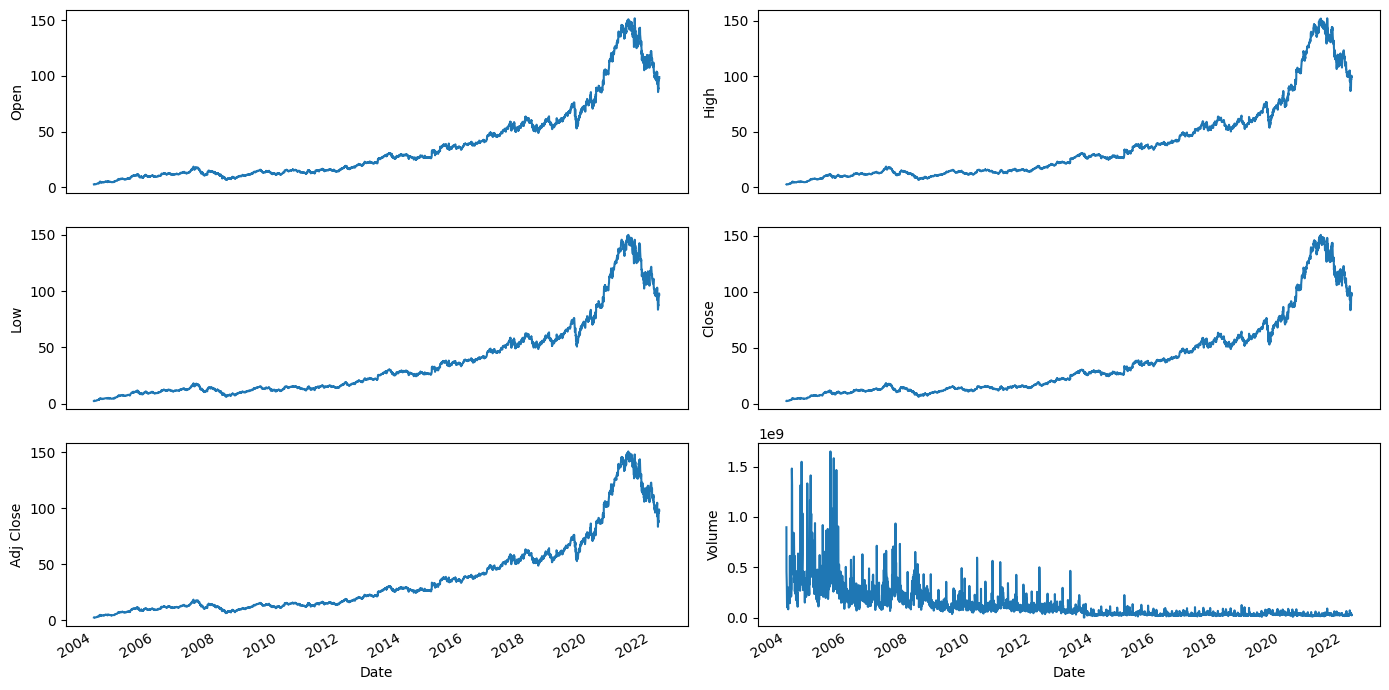

In [106]:
# Plot line charts
df_plot = data.copy()
#df_plot =df_plot.set_index('Date')
# df_plot.drop(['Date'], axis = 1 , inplace=True)

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

In [107]:
#drop the useless column
data = data.drop([ 'Adj Close'], axis = 1)

In [108]:
# split the data into training validation and testing 80/10/10
training_size = round((data.shape[0]*0.1)*8)
validation_size = round((data.shape[0]*0.1)*9)
test_size = round((data.shape[0]))
print(training_size,validation_size,test_size)

3678 4137 4597


In [113]:
# split the data into training validation and testing 80/10/10
# this is still dataframe
data_training = data.copy().iloc[:training_size, :]
data_validation = data.copy().iloc[training_size:validation_size, :]
data_test =data.copy().iloc[validation_size:test_size, :].copy()
data_test

,Open,High,Low,Close,Volume
Date,,,,,
2021-01-26,94.442001,96.250000,94.212250,95.862000,26262000
2021-01-27,94.126503,94.500000,90.449997,91.539497,54966000
2021-01-28,92.196999,94.941498,92.132004,93.155502,35462000
2021-01-29,92.308502,92.863998,90.510002,91.787003,32252000
2021-02-01,92.678497,96.119598,92.546501,95.067497,32044000
...,...,...,...,...,...
2022-11-14,95.500000,97.180000,95.112999,96.029999,24170100
2022-11-15,98.669998,100.419998,97.019997,98.720001,31831000
2022-11-16,98.019997,99.849998,97.902000,98.989998,24660200


In [110]:
# # split the data into training validation and testing 80/10/10
# data_training = data[data['Date']<'2021-01-01'].copy()
# data_validation = data[data['Date']<'2021-01-01'].copy()
# data_test = data[data['Date']>='2021-01-01'].copy()

In [111]:
# print the size of the data
print(data_training.shape[0], data_validation.shape[0], data_test.shape[0])

3678 459 460


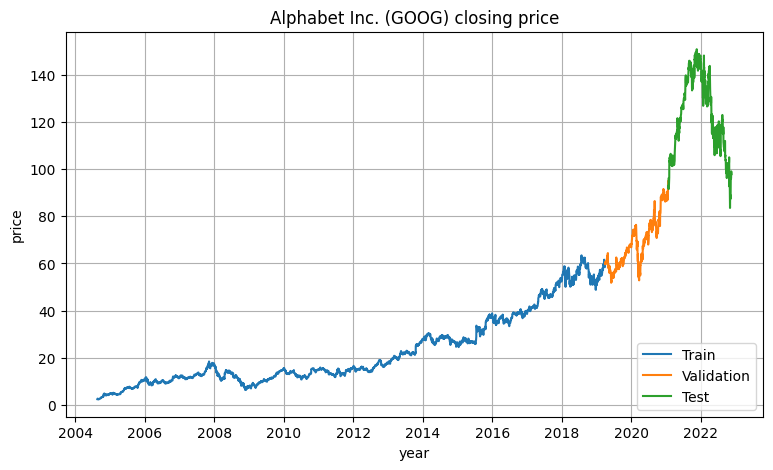

In [120]:
#plot the actual closing price for train, validation and test in 5 years
fig, ax = plt.subplots(figsize=(9, 5), sharex=True)
plt.plot(data_training.index, data_training.Close)
plt.plot(data_validation.index, data_validation.Close)
plt.plot(data_test.index, data_test.Close)
plt.title("Alphabet Inc. (GOOG) closing price")
plt.grid()
plt.xticks()
plt.ylabel("price")
plt.xlabel("year")
plt.legend(['Train', 'Validation', 'Test'], loc ='lower right')


In [146]:
# use min max scale
scaler_RNN = MinMaxScaler()

# scaled the training data in numpy array
scaled_data_training = scaler_RNN.fit_transform(data_training) # scaled the training data

# scaled the validation data in numpy array
scaled_data_validation = scaler_RNN.fit_transform(data_validation)

# scaled the testing data in numpy array
scaled_data_test = scaler_RNN.fit_transform(data_test)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
# df_training_Close = pd.DataFrame(data_training['Close'])
df_training_Close = pd.DataFrame(data['Close'])
scaled_training_Close = scaler_pred.fit_transform(df_training_Close)

df_training_Close

,Close
Date,
2004-08-19,2.499133
2004-08-20,2.697639
2004-08-23,2.724787
2004-08-24,2.611960
2004-08-25,2.640104
...,...
2022-11-14,96.029999
2022-11-15,98.720001
2022-11-16,98.989998


In [147]:
def partition_dataset(window_size, data):
    #using for loop to create the slide window
    X = []
    y = []

    for i in range(window_size, data.shape[0]):
        X.append(data[i-window_size:i])
        y.append(data[i, 3])

    X, y = np.array(X), np.array(y)
    
    return X, y 

In [15]:
# create differernt sequence length 10, 50 ,100
# sequence length of 10
def window_mod(ipt):
    if ipt == 10:
        window_size_10 = 10

        X_train_ten, y_train_ten = partition_dataset(window_size_10, scaled_data_training)
        X_val_ten, y_val_ten = partition_dataset(window_size_10, scaled_data_validation)
        X_test_ten, y_test_ten = partition_dataset(window_size_10, scaled_data_test)
        return X_train_ten, y_train_ten,X_val_ten, y_val_ten,X_test_ten, y_test_ten 

    # sequence length of 50
    elif ipt == 50:
        window_size_50 = 50

        X_train_fifty, y_train_fifty = partition_dataset(window_size_50, scaled_data_training)
        X_val_fifty, y_val_fifty = partition_dataset(window_size_50, scaled_data_validation)
        X_test_fifty, y_test_fifty = partition_dataset(window_size_50, scaled_data_test)
        return X_train_fifty, y_train_fifty,X_val_fifty, y_val_fifty,X_test_fifty, y_test_fifty

    # sequence length of 100
    elif ipt == 100:
        window_size_100 = 100

        X_train_100, y_train_100 = partition_dataset(window_size_100, scaled_data_training)
        X_val_100, y_val_100 = partition_dataset(window_size_100, scaled_data_validation)
        X_test_100, y_test_100 = partition_dataset(window_size_100, scaled_data_test)
        return X_train_100, y_train_100,X_val_100, y_val_100,X_test_100, y_test_100

## Simple RNN 
### sequence length 10/50/100, lr = 0,01

In [16]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, SimpleRNN, GRU

unit = sequence length
X_train.shape[1]
X_train.shape[2]

In [17]:
ipt = 10
X_train_ten, y_train_ten,X_val_ten, y_val_ten,X_test_ten, y_test_ten  = window_mod(ipt)
print("Sequence length is 10")
print("X_train:",X_train_ten.shape, "y_train:",y_train_ten.shape,"X_val:",X_val_ten.shape, "y_val:",y_val_ten.shape,"X_test:",X_test_ten.shape, "y_test:",y_test_ten.shape) 
# print(X_train_fifty.shape, y_train_fifty.shape)
# print(X_train_100.shape, y_train_100.shape)
# print(X_train_fifty.shape, y_train_fifty.shape)
# print(X_train_100.shape, y_train_100.shape)

Sequence length is 10
X_train: (3668, 10, 5) y_train: (3668,) X_val: (449, 10, 5) y_val: (449,) X_test: (450, 10, 5) y_test: (450,)


In [18]:

### sequence length 10, lr = 0,01
units = X_train_ten.shape[1] * X_train_ten.shape[2]
regressor_RNN_10 = Sequential()

# adding first RNN layer and dropout regulatization
regressor_RNN_10.add(SimpleRNN(units = units , activation = "tanh", dropout=0.2, return_sequences = True, input_shape = (X_train_ten.shape[1],5)))

# adding second RNN layer and dropout regulatization
regressor_RNN_10.add(SimpleRNN(units = 50, activation = "tanh", dropout=0.2, return_sequences = True))

# adding third RNN layer and dropout regulatization
regressor_RNN_10.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = False))

# adding the output layer
regressor_RNN_10.add(Dense(units = 1))

# compiling RNN
opt = keras.optimizers.Adam(learning_rate=0.001)
regressor_RNN_10.compile(optimizer = opt, loss = "mean_squared_error",metrics = ["accuracy"])


In [19]:
regressor_RNN_10.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10, 50)            2800      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10, 50)            5050      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 12,951
Trainable params: 12,951
Non-trainable params: 0
_________________________________________________________________


In [20]:
ipt = 50
X_train_fifty, y_train_fifty,X_val_fifty, y_val_fifty,X_test_fifty, y_test_fifty  = window_mod(ipt)
print("Sequence length is 50")
print("X_train:",X_train_fifty.shape, "y_train:",y_train_fifty.shape,"X_val:",X_val_fifty.shape, "y_val:",y_val_fifty.shape,"X_test:",X_test_fifty.shape, "y_test:",y_test_fifty.shape) 
# print(X_train_fifty.shape, y_train_fifty.shape)
# print(X_train_100.shape, y_train_100.shape)

Sequence length is 50
X_train: (3628, 50, 5) y_train: (3628,) X_val: (409, 50, 5) y_val: (409,) X_test: (410, 50, 5) y_test: (410,)


In [21]:
# initializing the RNN
learning_rate=0.001

regressor_RNN_50 = Sequential()


### sequence length 10, lr = 0,01
units = X_train_fifty.shape[1] * X_train_fifty.shape[2]
regressor_RNN_50 = Sequential()

# adding first RNN layer and dropout regulatization
regressor_RNN_50.add(SimpleRNN(units = units , activation = "tanh", dropout=0.2, return_sequences = True, input_shape = (X_train_fifty.shape[1],5)))

# adding second RNN layer and dropout regulatization
regressor_RNN_50.add(SimpleRNN(units = 50, activation = "tanh", dropout=0.2, return_sequences = True))

# adding third RNN layer and dropout regulatization
regressor_RNN_50.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = False))

# adding the output layer
regressor_RNN_50.add(Dense(units = 1))

# compiling RNN
opt = keras.optimizers.Adam(learning_rate)
regressor_RNN_50.compile(optimizer = opt, loss = "mean_squared_error",metrics = ["accuracy"])


In [22]:
regressor_RNN_50.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 50, 250)           64000     
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 50, 50)            15050     
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 84,151
Trainable params: 84,151
Non-trainable params: 0
_________________________________________________________________


In [23]:
ipt = 100
X_train_100, y_train_100,X_val_100, y_val_100,X_test_100, y_test_100  = window_mod(ipt)
print("Sequence length is 50")
print("X_train:",X_train_100.shape, "y_train:",y_train_100.shape,"X_val:",X_val_100.shape, "y_val:",y_val_100.shape,"X_test:",X_test_100.shape, "y_test:",y_test_100.shape) 
# print(X_train_fifty.shape, y_train_fifty.shape)
# print(X_train_100.shape, y_train_100.shape)

Sequence length is 50
X_train: (3578, 100, 5) y_train: (3578,) X_val: (359, 100, 5) y_val: (359,) X_test: (360, 100, 5) y_test: (360,)


In [24]:
# maybe change the dropout
# initializing the RNN
learning_rate=0.001

regressor_RNN_100 = Sequential()


### sequence length 10, lr = 0,01
units = X_train_100.shape[1] * X_train_100.shape[2]
regressor_RNN_100 = Sequential()

# adding first RNN layer and dropout regulatization
regressor_RNN_100.add(SimpleRNN(units = units, activation = "tanh", dropout=0.2, return_sequences = True, input_shape = (X_train_100.shape[1],5)))

# adding second RNN layer and dropout regulatization
regressor_RNN_100.add(SimpleRNN(units = 50, activation = "tanh", dropout=0.2, return_sequences = True))

# adding third RNN layer and dropout regulatization
regressor_RNN_100.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = False))

# adding the output layer
regressor_RNN_100.add(Dense(units = 1))

# compiling RNN
opt = keras.optimizers.Adam(learning_rate)
regressor_RNN_100.compile(optimizer = opt, loss = "mean_squared_error",metrics = ["accuracy"])


In [25]:
regressor_RNN_100.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 100, 500)          253000    
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 100, 50)           27550     
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 285,651
Trainable params: 285,651
Non-trainable params: 0
_________________________________________________________________


In [26]:
# fitting the RNN
epochs = 50
batch_size = 32
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history_RNN_10 = regressor_RNN_10.fit(X_train_ten, y_train_ten, epochs, batch_size , validation_data= (X_val_ten , y_val_ten), callbacks=[early_stop])
history_RNN_50 = regressor_RNN_50.fit(X_train_fifty, y_train_fifty, epochs, batch_size , validation_data= (X_val_fifty , y_val_fifty), callbacks=[early_stop])
history_RNN_100 = regressor_RNN_100.fit(X_train_100, y_train_100, epochs, batch_size , validation_data= (X_val_100 , y_val_100), callbacks=[early_stop])



Epoch 1/32


2022-11-22 17:27:10.742393: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


74/74 [==============================] - 1s 5ms/step - loss: 0.1106 - accuracy: 5.4526e-04 - val_loss: 0.0130 - val_accuracy: 0.0045
Epoch 2/32
74/74 [==============================] - 0s 3ms/step - loss: 0.0131 - accuracy: 5.4526e-04 - val_loss: 0.0067 - val_accuracy: 0.0045
Epoch 3/32
74/74 [==============================] - 0s 3ms/step - loss: 0.0068 - accuracy: 5.4526e-04 - val_loss: 0.0076 - val_accuracy: 0.0045
Epoch 4/32
74/74 [==============================] - 0s 3ms/step - loss: 0.0048 - accuracy: 5.4526e-04 - val_loss: 0.0117 - val_accuracy: 0.0045
Epoch 5/32
74/74 [==============================] - 0s 3ms/step - loss: 0.0040 - accuracy: 5.4526e-04 - val_loss: 0.0125 - val_accuracy: 0.0045
Epoch 6/32
74/74 [==============================] - 0s 3ms/step - loss: 0.0032 - accuracy: 5.4526e-04 - val_loss: 0.0111 - val_accuracy: 0.0045
Epoch 7/32
74/74 [==============================] - 0s 3ms/step - loss: 0.0033 - accuracy: 5.4526e-04 - val_loss: 0.0158 - val_accuracy: 0.0045
Epo

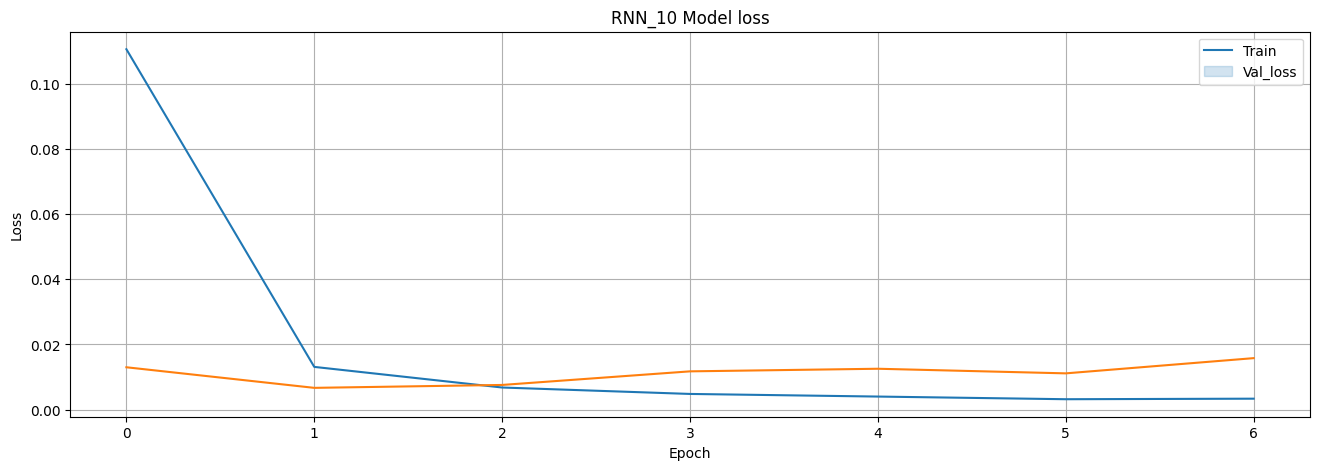

In [27]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history_RNN_10.history["loss"])
sns.lineplot(data=history_RNN_10.history["val_loss"])
plt.title("RNN_10 Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val_loss"])
plt.grid()
plt.show()

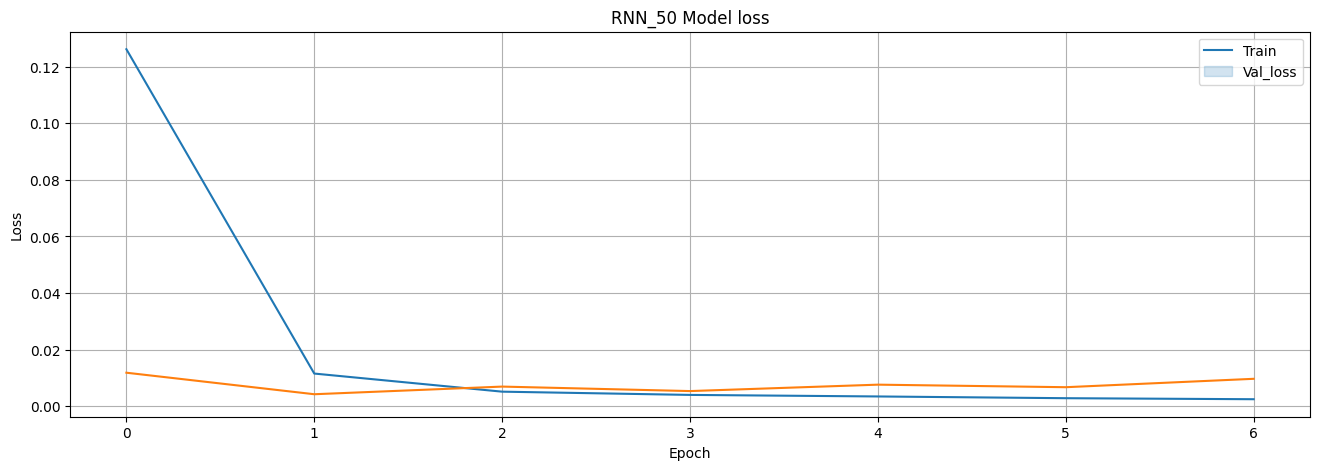

In [28]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history_RNN_50.history["loss"])
sns.lineplot(data=history_RNN_50.history["val_loss"])
plt.title("RNN_50 Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val_loss"])
plt.grid()
plt.show()

In [29]:
history_RNN_50.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

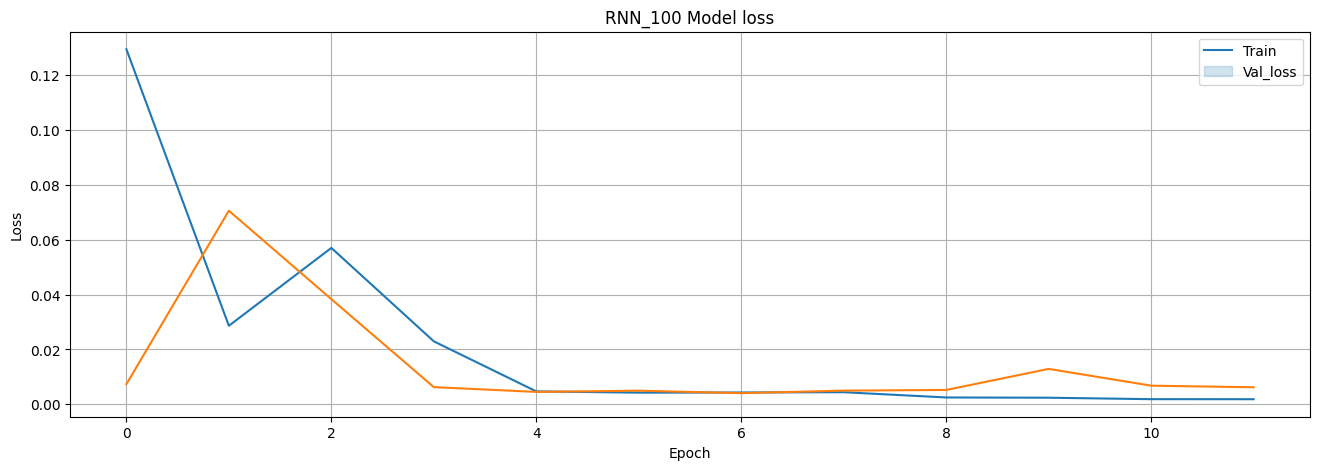

In [30]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history_RNN_100.history["loss"])
sns.lineplot(data=history_RNN_100.history["val_loss"])
plt.title("RNN_100 Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val_loss"])
plt.grid()
plt.show()

In [31]:
# # Plotting Loss vs Epochs
# plt.figure(figsize =(5,3))
# plt.plot(history_RNN.history["loss"])
# plt.xlabel("Epochs")
# plt.ylabel("Losses")
# plt.title("Simple RNN model, Loss vs Epoch")
# plt.show()

In [133]:
def get_MAE(X_val,y_val,regressor):
    # Get the predicted values
    y_pred_scaled = regressor.predict(X_val)

    # Unscale the predicted values
    y_pred = scaler_pred.inverse_transform(y_pred_scaled)
    y_val_unscaled = scaler_pred.inverse_transform(y_val.reshape(-1, 1))
    
    # RMSEMean Square Error (MSE)
    RMSE = mean_squared_error(y_val_unscaled, y_pred, squared=False)
    print(f'Mean Square Error (MSE): {np.round(RMSE, 2)}')

    # Mean Absolute Error (MAE)
    MAE = mean_absolute_error(y_val_unscaled, y_pred)
    print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')

    # Mean Absolute Percentage Error (MAPE)
    MAPE = np.mean((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled))) * 100
    print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

    # Median Absolute Percentage Error (MDAPE)
    MDAPE = np.median((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled)) ) * 100
    print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
    print(len(y_pred))
    
    return True

In [134]:
print("regressor_RNN_10")
get_MAE(X_val_ten,y_val_ten,regressor_RNN_10)

print("regressor_RNN_50")
get_MAE(X_val_fifty,y_val_fifty,regressor_RNN_50)

print("regressor_RNN_100")
get_MAE(X_val_100,y_val_100,regressor_RNN_100)

regressor_RNN_10
15/15 [==============================] - 0s 866us/step
Mean Square Error (MSE): 18.63
Mean Absolute Error (MAE): 15.61
Mean Absolute Percentage Error (MAPE): 29.32 %
Median Absolute Percentage Error (MDAPE): 25.03 %
449
regressor_RNN_50
13/13 [==============================] - 0s 7ms/step
Mean Square Error (MSE): 14.57
Mean Absolute Error (MAE): 11.88
Mean Absolute Percentage Error (MAPE): 22.58 %
Median Absolute Percentage Error (MDAPE): 17.74 %
409
regressor_RNN_100
12/12 [==============================] - 0s 24ms/step
Mean Square Error (MSE): 11.67
Mean Absolute Error (MAE): 9.11
Mean Absolute Percentage Error (MAPE): 18.04 %
Median Absolute Percentage Error (MDAPE): 11.68 %
359


True

# LSTM

In [96]:
# initializing the LSTM
learning_rate=0.001

regressor_LSTM_10 = Sequential()

### sequence length 10, lr = 0,01
units = X_train_ten.shape[1] * X_train_ten.shape[2]
regressor_LSTM_10 = Sequential()

# adding first RNN layer and dropout regulatization
regressor_LSTM_10.add(LSTM(units = units , activation = "tanh", dropout=0.2, return_sequences = True, input_shape = (X_train_ten.shape[1],5)))

# adding second RNN layer and dropout regulatization
regressor_LSTM_10.add(LSTM(units = 50, activation = "tanh", dropout=0.2, return_sequences = True))

# adding third RNN layer and dropout regulatization
regressor_LSTM_10.add(LSTM(units = 50, activation = "tanh", return_sequences = False))

# adding the output layer
regressor_LSTM_10.add(Dense(units = 1))

# compiling RNN
opt = keras.optimizers.Adam(learning_rate)
regressor_LSTM_10.compile(optimizer = opt, loss = "mean_squared_error",metrics = ["accuracy"])


In [97]:
regressor_LSTM_10.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 10, 50)            11200     
                                                                 
 lstm_10 (LSTM)              (None, 10, 50)            20200     
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 51,651
Trainable params: 51,651
Non-trainable params: 0
_________________________________________________________________


In [37]:
# initializing the LSTM
learning_rate=0.001

regressor_LSTM_50 = Sequential()

### sequence length 10, lr = 0,01
units = X_train_fifty.shape[1] * X_train_fifty.shape[2]
regressor_LSTM_50 = Sequential()

# adding first RNN layer and dropout regulatization
regressor_LSTM_50.add(LSTM(units = units , activation = "tanh", dropout=0.2, return_sequences = True, input_shape = (X_train_fifty.shape[1],5)))

# adding second RNN layer and dropout regulatization
regressor_LSTM_50.add(LSTM(units = 50, activation = "tanh", dropout=0.2, return_sequences = True))

# adding third RNN layer and dropout regulatization
regressor_LSTM_50.add(LSTM(units = 50, activation = "tanh", return_sequences = False))

# adding the output layer
regressor_LSTM_50.add(Dense(units = 1))

# compiling RNN
opt = keras.optimizers.Adam(learning_rate)
regressor_LSTM_50.compile(optimizer = opt, loss = "mean_squared_error",metrics = ["accuracy"])


In [38]:
regressor_LSTM_50.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50, 250)           256000    
                                                                 
 lstm_4 (LSTM)               (None, 50, 50)            60200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 336,451
Trainable params: 336,451
Non-trainable params: 0
_________________________________________________________________


In [39]:
# initializing the LSTM
learning_rate=0.001

regressor_LSTM_100 = Sequential()

### sequence length 10, lr = 0,01
units = X_train_100.shape[1] * X_train_100.shape[2]
regressor_LSTM_100 = Sequential()

# adding first RNN layer and dropout regulatization
regressor_LSTM_100.add(LSTM(units = units , activation = "tanh", dropout=0.2, return_sequences = True, input_shape = (X_train_100.shape[1],5)))

# adding second RNN layer and dropout regulatization
regressor_LSTM_100.add(LSTM(units = 50, activation = "tanh", dropout=0.2, return_sequences = True))

# adding third RNN layer and dropout regulatization
regressor_LSTM_100.add(LSTM(units = 50, activation = "tanh", return_sequences = False))

# adding the output layer
regressor_LSTM_100.add(Dense(units = 1))

# compiling RNN
opt = keras.optimizers.Adam(learning_rate)
regressor_LSTM_100.compile(optimizer = opt, loss = "mean_squared_error",metrics = ["accuracy"])


In [40]:
regressor_LSTM_100.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 500)          1012000   
                                                                 
 lstm_7 (LSTM)               (None, 100, 50)           110200    
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,142,451
Trainable params: 1,142,451
Non-trainable params: 0
_________________________________________________________________


In [41]:
# fitting the RNN
epochs = 50
batch_size = 32
history_LSTM_10 = regressor_LSTM_10.fit(X_train_ten, y_train_ten, epochs, batch_size , validation_data= (X_val_ten , y_val_ten), callbacks=[early_stop])
history_LSTM_50 = regressor_LSTM_50.fit(X_train_fifty, y_train_fifty, epochs, batch_size , validation_data= (X_val_fifty , y_val_fifty), callbacks=[early_stop])
history_LSTM_100 = regressor_LSTM_100.fit(X_train_100, y_train_100, epochs, batch_size , validation_data= (X_val_100 , y_val_100), callbacks=[early_stop])


Epoch 1/32
74/74 [==============================] - 3s 12ms/step - loss: 0.0126 - accuracy: 5.4526e-04 - val_loss: 0.0056 - val_accuracy: 0.0045
Epoch 2/32
74/74 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 5.4526e-04 - val_loss: 0.0059 - val_accuracy: 0.0045
Epoch 3/32
74/74 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 5.4526e-04 - val_loss: 0.0059 - val_accuracy: 0.0045
Epoch 4/32
74/74 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 5.4526e-04 - val_loss: 0.0045 - val_accuracy: 0.0045
Epoch 5/32
74/74 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 5.4526e-04 - val_loss: 0.0039 - val_accuracy: 0.0045
Epoch 6/32
74/74 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 5.4526e-04 - val_loss: 0.0046 - val_accuracy: 0.0045
Epoch 7/32
74/74 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 5.4526e-04 - val_loss: 0.0051 - val_accuracy

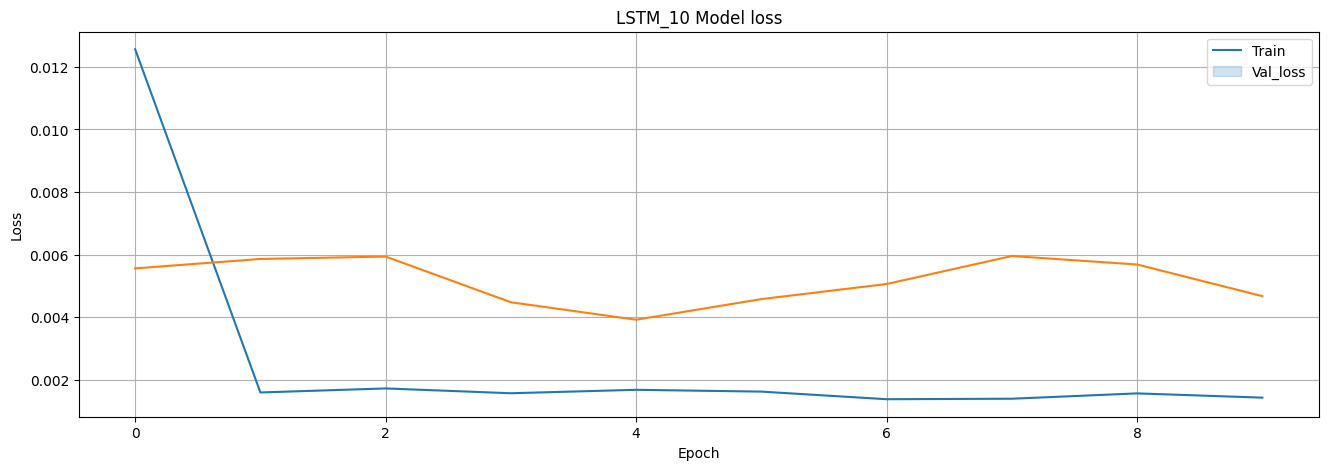

In [43]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history_LSTM_10.history["loss"])
sns.lineplot(data=history_LSTM_10.history["val_loss"])
plt.title("LSTM_10 Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val_loss"])
plt.grid()
plt.show()

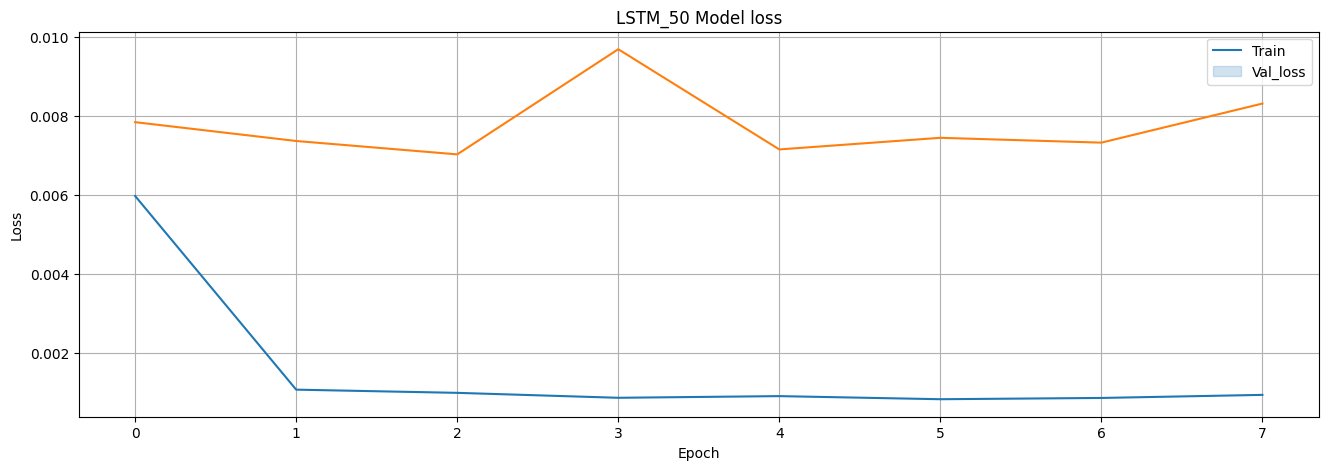

In [44]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history_LSTM_50.history["loss"])
sns.lineplot(data=history_LSTM_50.history["val_loss"])
plt.title("LSTM_50 Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val_loss"])
plt.grid()
plt.show()

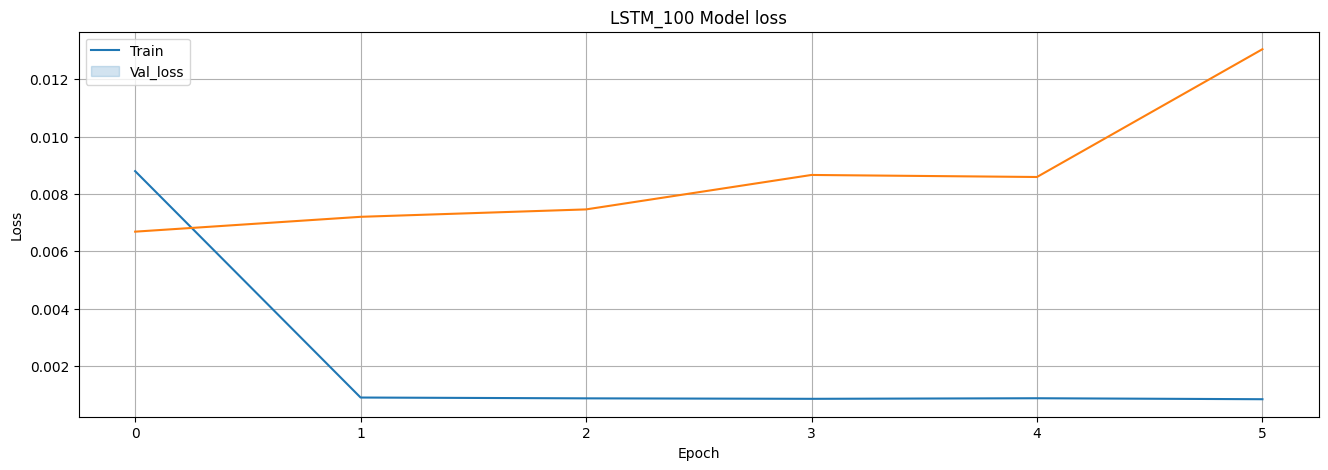

In [45]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history_LSTM_100.history["loss"])
sns.lineplot(data=history_LSTM_100.history["val_loss"])
plt.title("LSTM_100 Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val_loss"])
plt.grid()
plt.show()

In [135]:
print("regressor_LSTM_10")
get_MAE(X_val_ten,y_val_ten,regressor_LSTM_10)

print("regressor_LSTM_50")
get_MAE(X_val_fifty,y_val_fifty,regressor_LSTM_50)

print("regressor_LSTM_100")
get_MAE(X_val_100,y_val_100,regressor_LSTM_100)

regressor_LSTM_10
15/15 [==============================] - 0s 2ms/step
Mean Square Error (MSE): 68.5
Mean Absolute Error (MAE): 59.16
Mean Absolute Percentage Error (MAPE): 95.04 %
Median Absolute Percentage Error (MDAPE): 95.62 %
449
regressor_LSTM_50
13/13 [==============================] - 0s 17ms/step
Mean Square Error (MSE): 13.51
Mean Absolute Error (MAE): 10.65
Mean Absolute Percentage Error (MAPE): 22.64 %
Median Absolute Percentage Error (MDAPE): 16.09 %
409
regressor_LSTM_100
12/12 [==============================] - 1s 69ms/step
Mean Square Error (MSE): 16.93
Mean Absolute Error (MAE): 14.36
Mean Absolute Percentage Error (MAPE): 25.9 %
Median Absolute Percentage Error (MDAPE): 20.73 %
359


True

# GRU

In [47]:
# initializing the GRU
learning_rate=0.001

regressor_GRU_10 = Sequential()

### sequence length 10, lr = 0,01
units = X_train_ten.shape[1] * X_train_ten.shape[2]
regressor_GRU_10 = Sequential()

# adding first RNN layer and dropout regulatization
regressor_GRU_10.add(GRU(units = units , activation = "tanh", dropout=0.2, return_sequences = True, input_shape = (X_train_ten.shape[1],5)))

# adding second RNN layer and dropout regulatization
regressor_GRU_10.add(GRU(units = 50, activation = "tanh", dropout=0.2, return_sequences = True))

# adding third RNN layer and dropout regulatization
regressor_GRU_10.add(GRU(units = 50, activation = "tanh", return_sequences = False))

# adding the output layer
regressor_GRU_10.add(Dense(units = 1))

# compiling GRU
opt = keras.optimizers.Adam(learning_rate)
regressor_GRU_10.compile(optimizer = opt, loss = "mean_squared_error",metrics = ["accuracy"])


In [48]:
# initializing the GRU
learning_rate=0.001

regressor_GRU_50 = Sequential()

### sequence length 10, lr = 0,01
units = X_train_fifty.shape[1] * X_train_fifty.shape[2]
regressor_GRU_50 = Sequential()

# adding first RNN layer and dropout regulatization
regressor_GRU_50.add(GRU(units = units , activation = "tanh", dropout=0.2, return_sequences = True, input_shape = (X_train_fifty.shape[1],5)))

# adding second RNN layer and dropout regulatization
regressor_GRU_50.add(GRU(units = 50, activation = "tanh", dropout=0.2, return_sequences = True))

# adding third RNN layer and dropout regulatization
regressor_GRU_50.add(GRU(units = 50, activation = "tanh", return_sequences = False))

# adding the output layer
regressor_GRU_50.add(Dense(units = 1))

# compiling GRU
opt = keras.optimizers.Adam(learning_rate)
regressor_GRU_50.compile(optimizer = opt, loss = "mean_squared_error",metrics = ["accuracy"])


In [49]:
# initializing the GRU
learning_rate=0.001

regressor_GRU_100 = Sequential()

### sequence length 10, lr = 0,01
units = X_train_100.shape[1] * X_train_100.shape[2]
regressor_GRU_100 = Sequential()

# adding first RNN layer and dropout regulatization
regressor_GRU_100.add(GRU(units = units , activation = "tanh", dropout=0.2, return_sequences = True, input_shape = (X_train_100.shape[1],5)))

# adding second RNN layer and dropout regulatization
regressor_GRU_100.add(GRU(units = 50, activation = "tanh", dropout=0.2, return_sequences = True))

# adding third RNN layer and dropout regulatization
regressor_GRU_100.add(GRU(units = 50, activation = "tanh", return_sequences = False))

# adding the output layer
regressor_GRU_100.add(Dense(units = 1))

# compiling GRU
opt = keras.optimizers.Adam(learning_rate)
regressor_GRU_100.compile(optimizer = opt, loss = "mean_squared_error",metrics = ["accuracy"])


In [121]:
regressor_GRU_10.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_9 (GRU)                 (None, 10, 50)            8550      
                                                                 
 gru_10 (GRU)                (None, 10, 50)            15300     
                                                                 
 gru_11 (GRU)                (None, 50)                15300     
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 39,201
Trainable params: 39,201
Non-trainable params: 0
_________________________________________________________________


# Prediction

In [51]:
# fitting the RNN
epochs = 50
batch_size = 32
history_GRU_10 = regressor_GRU_10.fit(X_train_ten, y_train_ten, epochs, batch_size , validation_data= (X_val_ten , y_val_ten), callbacks=[early_stop])
history_GRU_50 = regressor_GRU_50.fit(X_train_fifty, y_train_fifty, epochs, batch_size , validation_data= (X_val_fifty , y_val_fifty), callbacks=[early_stop])
history_GRU_100 = regressor_GRU_100.fit(X_train_100, y_train_100, epochs, batch_size , validation_data= (X_val_100 , y_val_100), callbacks=[early_stop])



Epoch 1/32
74/74 [==============================] - 3s 12ms/step - loss: 0.0112 - accuracy: 5.4526e-04 - val_loss: 0.0029 - val_accuracy: 0.0045
Epoch 2/32
74/74 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 5.4526e-04 - val_loss: 0.0032 - val_accuracy: 0.0045
Epoch 3/32
74/74 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 5.4526e-04 - val_loss: 0.0030 - val_accuracy: 0.0045
Epoch 4/32
74/74 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 5.4526e-04 - val_loss: 0.0036 - val_accuracy: 0.0045
Epoch 5/32
74/74 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 5.4526e-04 - val_loss: 0.0033 - val_accuracy: 0.0045
Epoch 6/32
74/74 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 5.4526e-04 - val_loss: 0.0033 - val_accuracy: 0.0045
Epoch 6: early stopping
Epoch 1/32
73/73 [==============================] - 7s 67ms/step - loss: 0.0084 - accuracy: 2.7563e-04 - val_lo

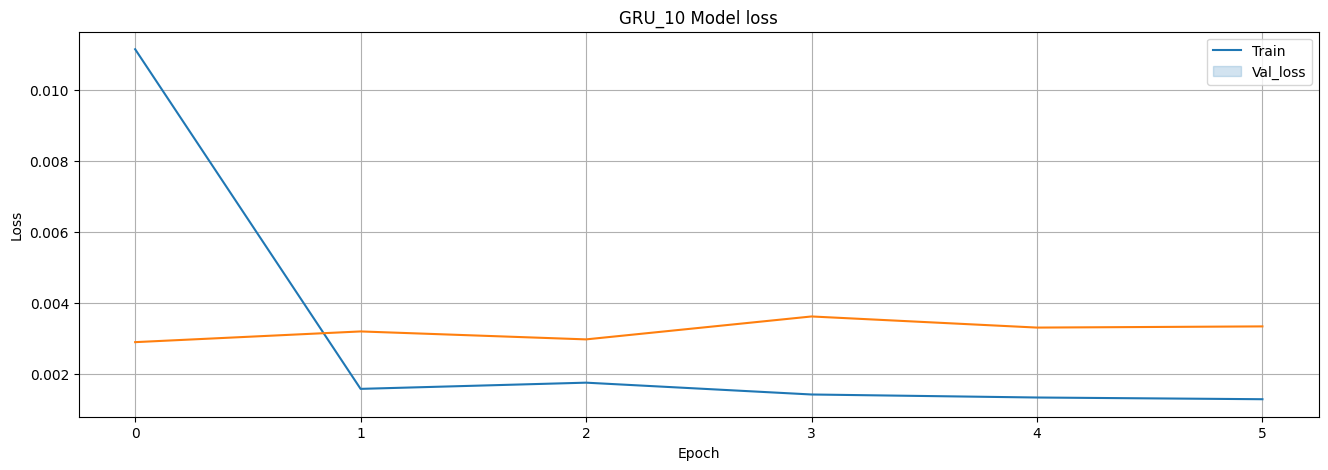

15/15 [==============================] - 0s 1ms/step
Median Absolute Error (MAE): 6.3


In [52]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history_GRU_10.history["loss"])
sns.lineplot(data=history_GRU_10.history["val_loss"])
plt.title("GRU_10 Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val_loss"])
plt.grid()
plt.show()
# Get the predicted values
y_pred_scaled = regressor_GRU_10.predict(X_val_ten)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_val_unscaled = scaler_pred.inverse_transform(y_val_ten.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_val_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

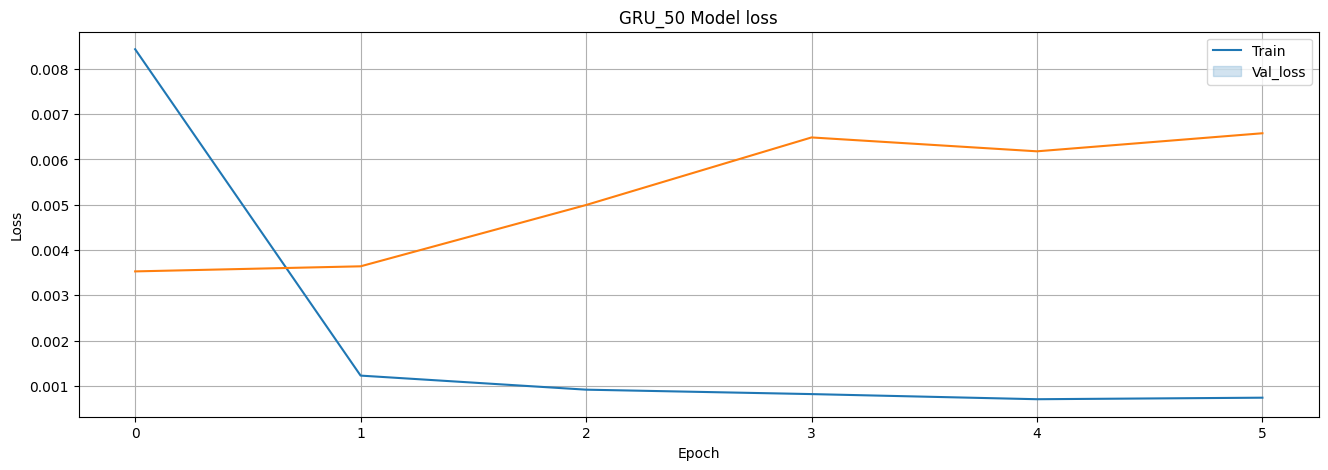

In [53]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history_GRU_50.history["loss"])
sns.lineplot(data=history_GRU_50.history["val_loss"])
plt.title("GRU_50 Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val_loss"])
plt.grid()
plt.show()

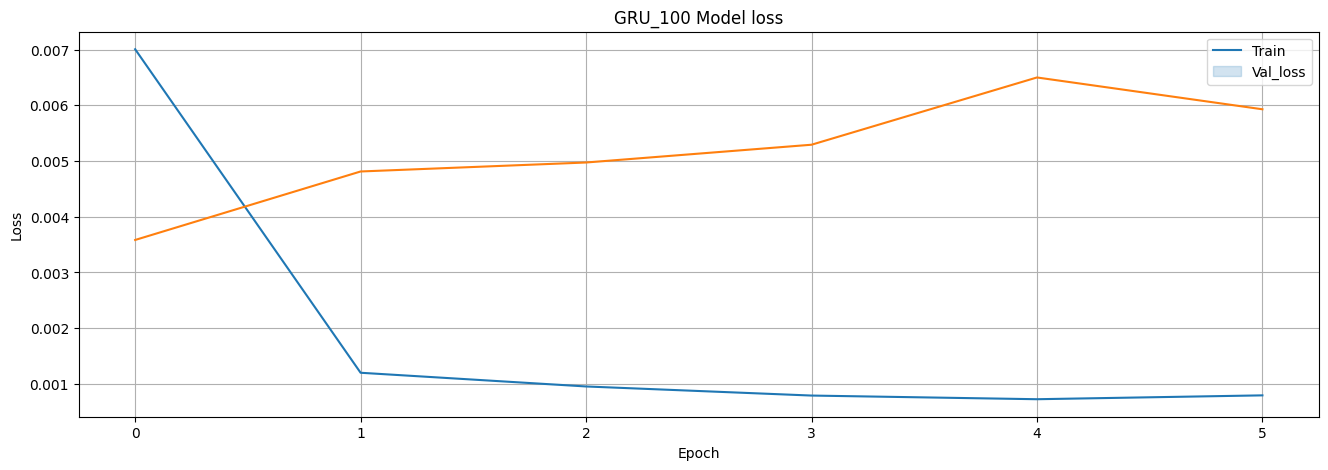

In [54]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history_GRU_100.history["loss"])
sns.lineplot(data=history_GRU_100.history["val_loss"])
plt.title("GRU_100 Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val_loss"])
plt.grid()
plt.show()

In [136]:
print("regressor_GRU_10")
get_MAE(X_val_ten,y_val_ten,regressor_GRU_10)

print("regressor_GRU_50")
get_MAE(X_val_fifty,y_val_fifty,regressor_GRU_50)

print("regressor_GRU_100")
get_MAE(X_val_100,y_val_100,regressor_GRU_100)

regressor_GRU_10
15/15 [==============================] - 0s 1ms/step
Mean Square Error (MSE): 54.43
Mean Absolute Error (MAE): 45.41
Mean Absolute Percentage Error (MAPE): 68.47 %
Median Absolute Percentage Error (MDAPE): 73.12 %
449
regressor_GRU_50
13/13 [==============================] - 0s 14ms/step
Mean Square Error (MSE): 12.02
Mean Absolute Error (MAE): 9.22
Mean Absolute Percentage Error (MAPE): 18.36 %
Median Absolute Percentage Error (MDAPE): 13.43 %
409
regressor_GRU_100
12/12 [==============================] - 1s 58ms/step
Mean Square Error (MSE): 11.41
Mean Absolute Error (MAE): 8.56
Mean Absolute Percentage Error (MAPE): 16.91 %
Median Absolute Percentage Error (MDAPE): 10.2 %
359


True

In [56]:
def prediction(model,window_size,X_train,y_train,X_val,y_val):
    
    train_predictions = model.predict(X_train).flatten()
    val_predictions = model.predict(X_val).flatten()
 #   test_predictions = model.predict(X_test).flatten()
    
    plt.figure(figsize=(15,5))
    plt.plot(data_training[window_size:].index, train_predictions)
    plt.plot(data_training[window_size:].index, y_train)
    
    plt.plot(data_validation[window_size:].index, val_predictions)
    plt.plot(data_validation[window_size:].index, y_val)
    
#     plt.plot(data_test[window_size:].index, test_predictions)
#     plt.plot(data_test[window_size:].index, y_test)
    plt.xticks(rotation=90)
    plt.grid
    
    return True


## prediction for RNN 10, 50,100

15/15 [==============================] - 0s 678us/step


True

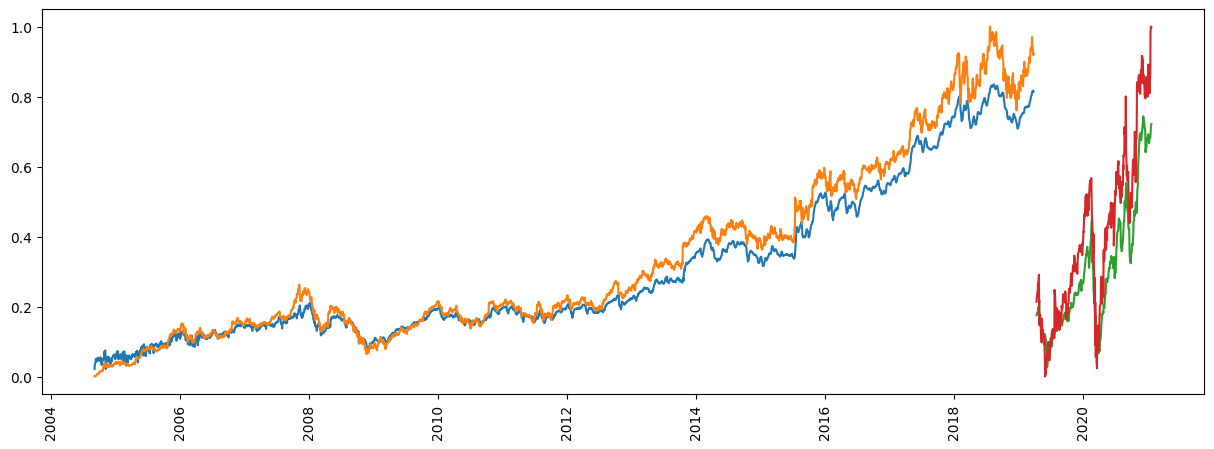

In [57]:
prediction(regressor_RNN_10, 10, X_train_ten, y_train_ten,X_val_ten, y_val_ten)

13/13 [==============================] - 0s 6ms/step


True

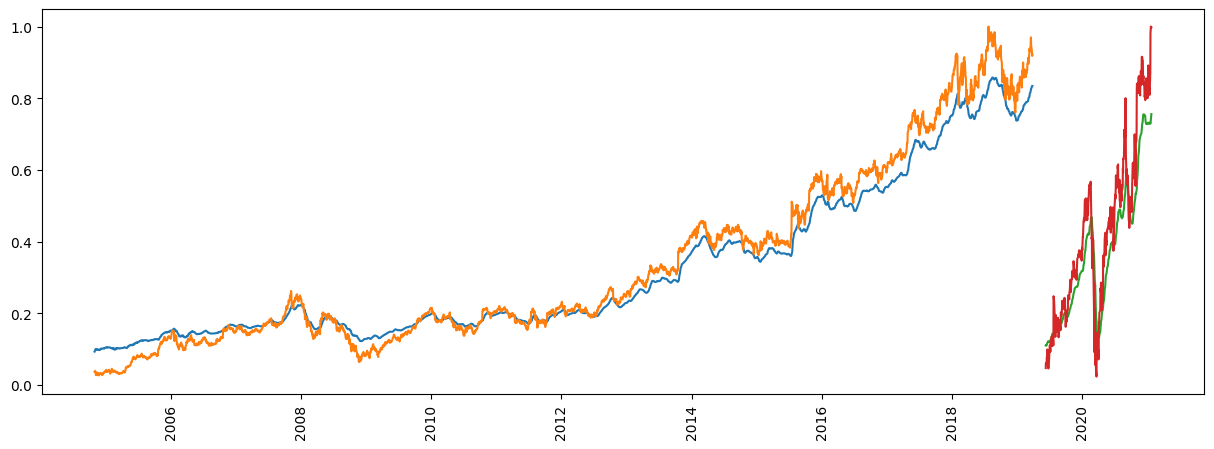

In [58]:
prediction(regressor_RNN_50, 50, X_train_fifty, y_train_fifty ,X_val_fifty, y_val_fifty)

12/12 [==============================] - 0s 23ms/step


True

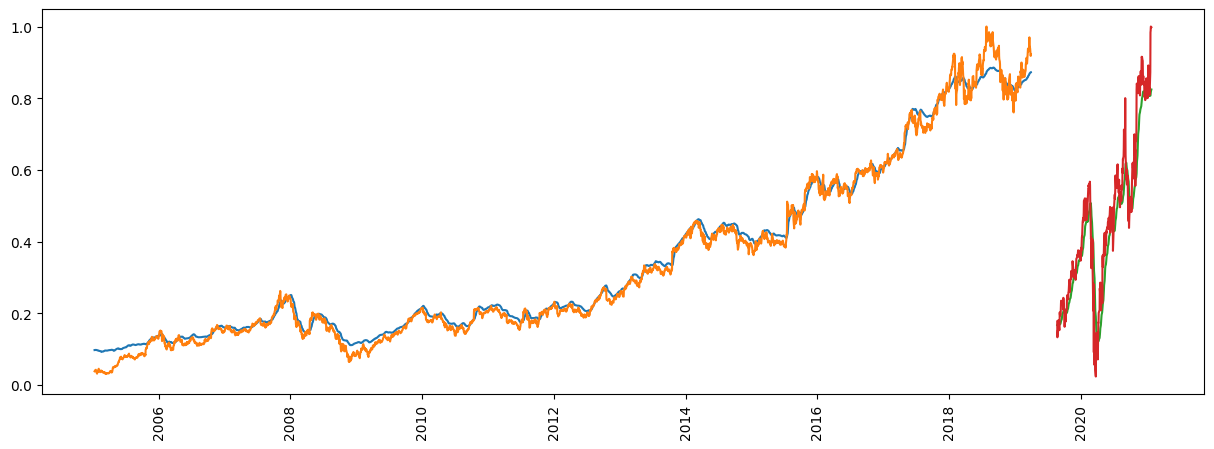

In [59]:
prediction(regressor_RNN_100, 100, X_train_100, y_train_100 ,X_val_100, y_val_100)

## prediction for LSTM 10, 50,100

15/15 [==============================] - 0s 1ms/step


True

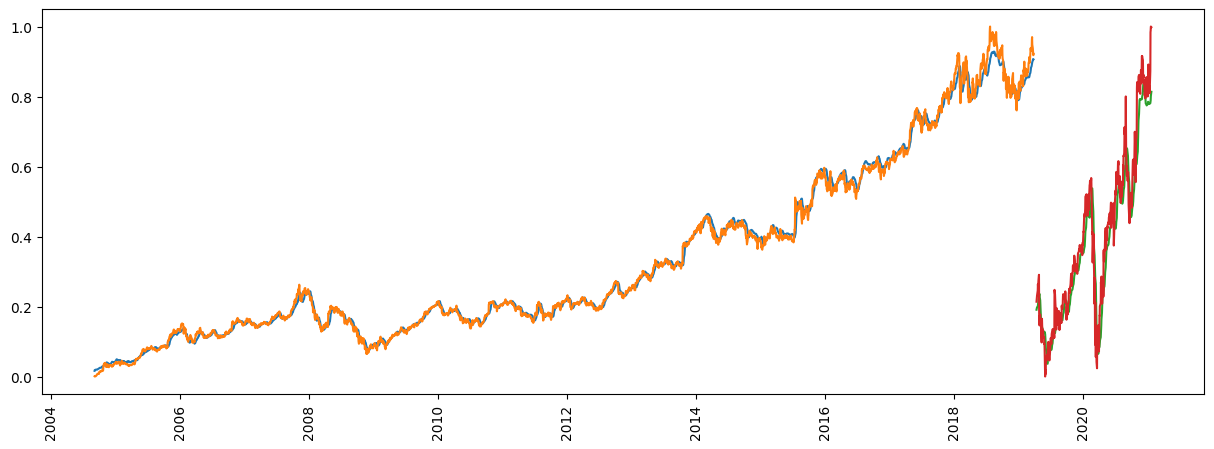

In [60]:
prediction(regressor_LSTM_10, 10, X_train_ten, y_train_ten,X_val_ten, y_val_ten)

13/13 [==============================] - 0s 17ms/step


True

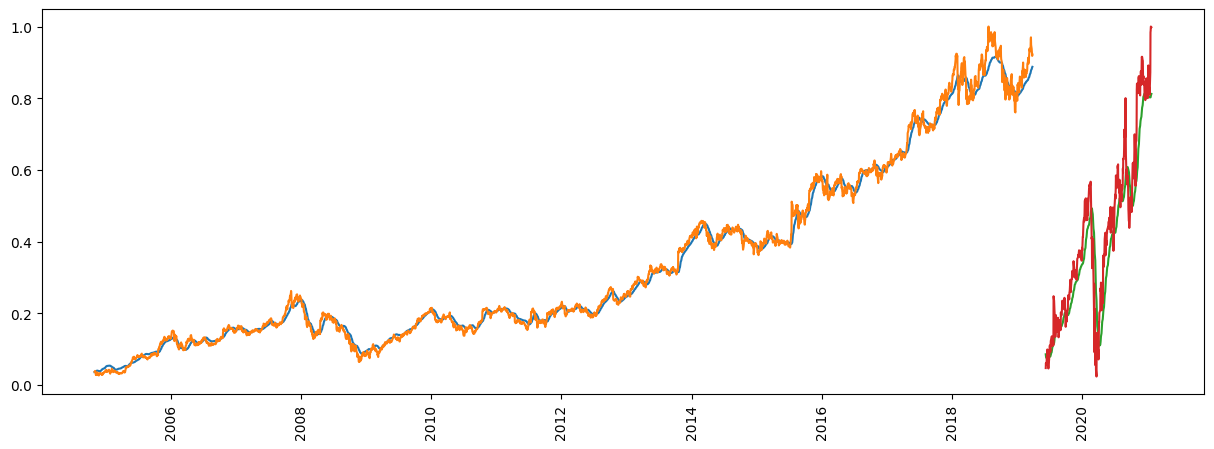

In [61]:
prediction(regressor_LSTM_50, 50, X_train_fifty, y_train_fifty ,X_val_fifty, y_val_fifty)

12/12 [==============================] - 1s 67ms/step


True

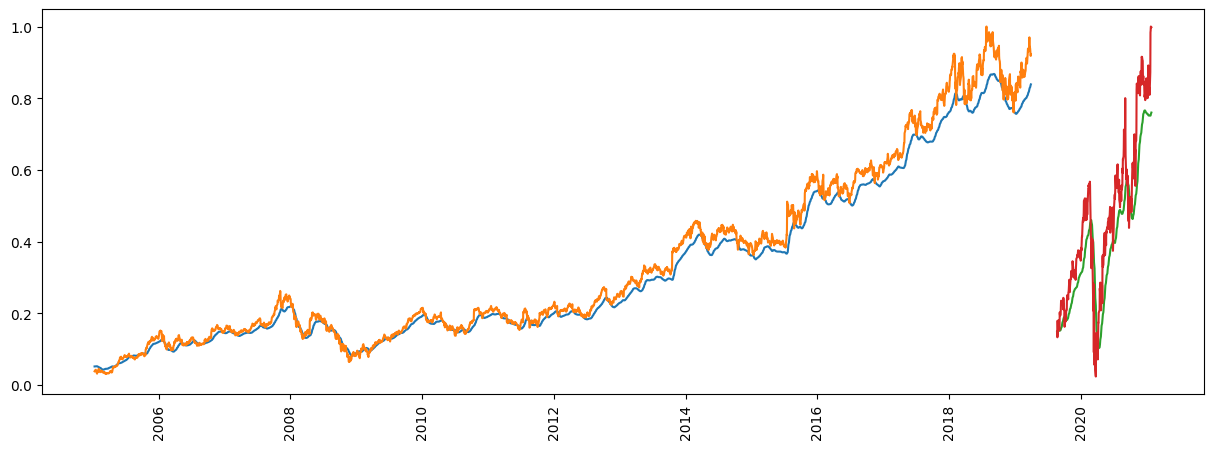

In [62]:
prediction(regressor_LSTM_100, 100, X_train_100, y_train_100 ,X_val_100, y_val_100)

## prediction for GRU 10, 50,100

15/15 [==============================] - 0s 1ms/step


True

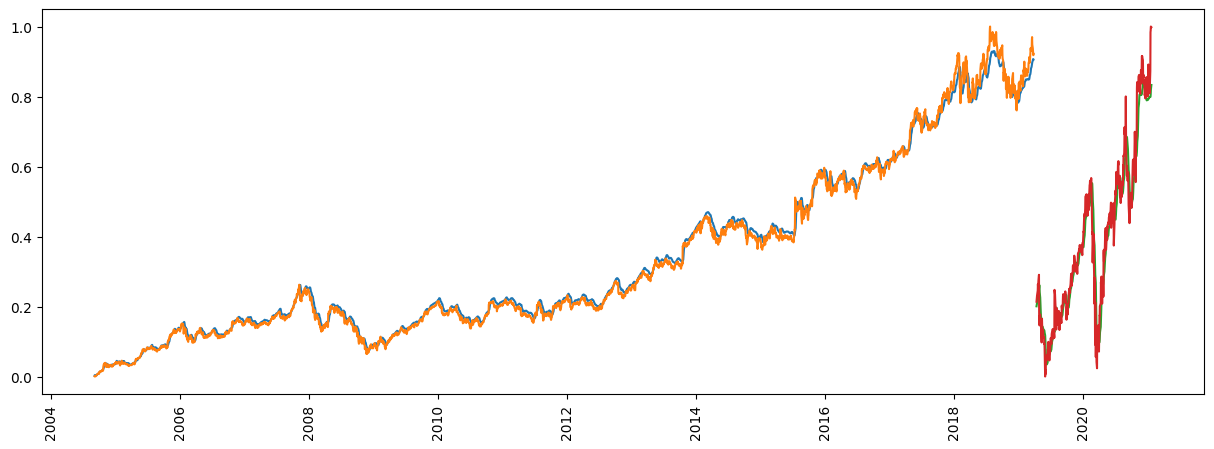

In [63]:
prediction(regressor_GRU_10, 10, X_train_ten, y_train_ten,X_val_ten, y_val_ten)

13/13 [==============================] - 0s 14ms/step


True

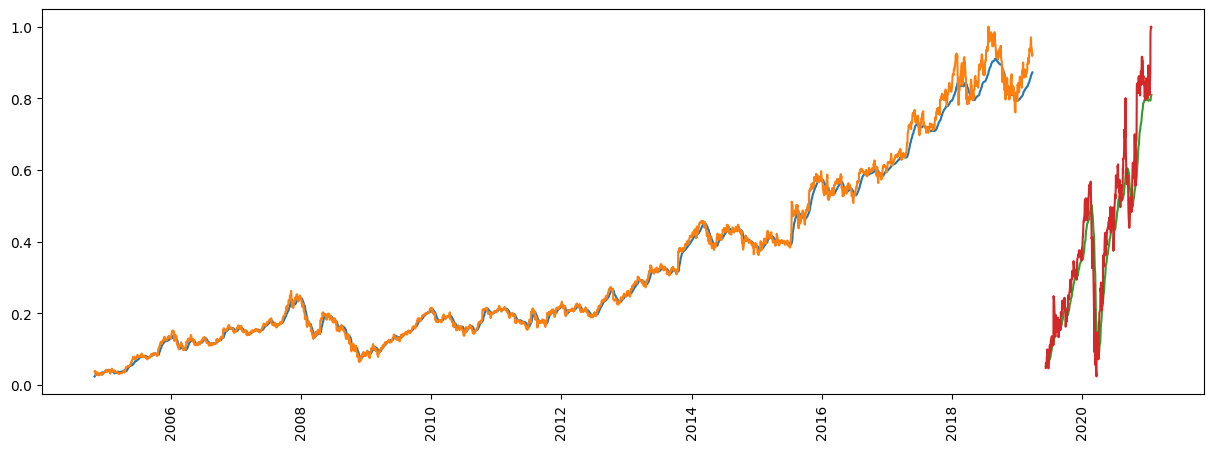

In [64]:
prediction(regressor_GRU_50, 50, X_train_fifty, y_train_fifty ,X_val_fifty, y_val_fifty)

12/12 [==============================] - 1s 56ms/step


True

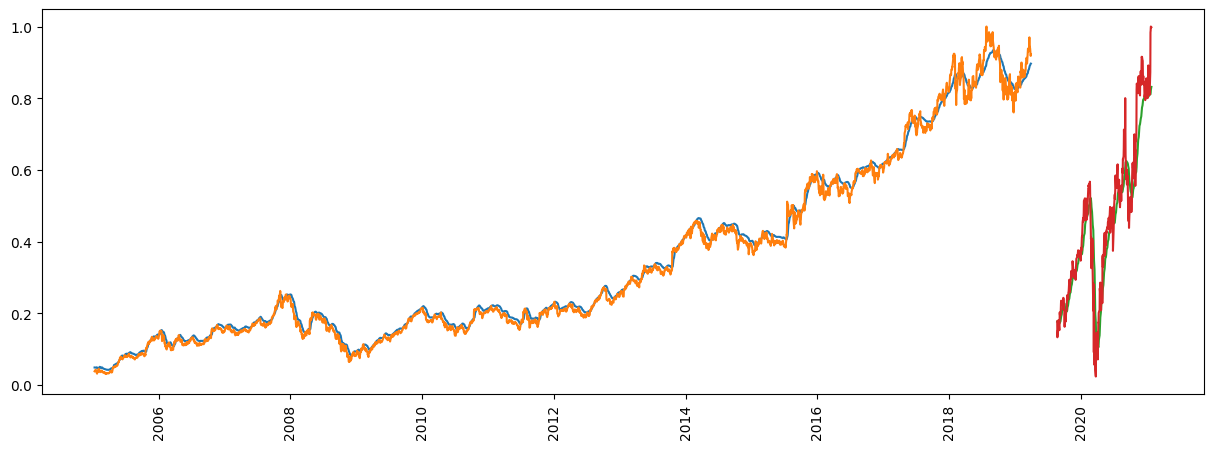

In [65]:
prediction(regressor_GRU_100, 100, X_train_100, y_train_100 ,X_val_100, y_val_100)

In [67]:
data_test

,Open,High,Low,Close,Volume
Date,,,,,
2021-01-26,94.442001,96.250000,94.212250,95.862000,26262000
2021-01-27,94.126503,94.500000,90.449997,91.539497,54966000
2021-01-28,92.196999,94.941498,92.132004,93.155502,35462000
2021-01-29,92.308502,92.863998,90.510002,91.787003,32252000
2021-02-01,92.678497,96.119598,92.546501,95.067497,32044000
...,...,...,...,...,...
2022-11-14,95.500000,97.180000,95.112999,96.029999,24170100
2022-11-15,98.669998,100.419998,97.019997,98.720001,31831000
2022-11-16,98.019997,99.849998,97.902000,98.989998,24660200


In [68]:
regressor_RNN_10.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10, 50)            2800      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10, 50)            5050      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 12,951
Trainable params: 12,951
Non-trainable params: 0
_________________________________________________________________


In [69]:
df_temp = scaled_data_test[-11:-1]
#new_df = df_temp

# N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
# last_N_days = new_df[-sequence_length:].values
# last_N_days_scaled = y_test_ten[-1]

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(df_temp)
# X_test_new
# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = regressor_RNN_10.predict(np.array(X_test_new))
# pred_price_scaled
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(df_temp[-1][3], 2)

predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
# print(f'The close price for {"stockname"} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 10ms/step
The predicted close price is 21.290000915527344 (+98.97%)


In [70]:
def prediction_price(model,sequence_length):
    df_temp = scaled_data_test[-sequence_length:-1]
    #new_df = df_temp

    # N = sequence_length

    # Get the last N day closing price values and scale the data to be values between 0 and 1
    # last_N_days = new_df[-sequence_length:].values
    # last_N_days_scaled = y_test_ten[-1]

    # Create an empty list and Append past N days
    X_test_new = []
    X_test_new.append(df_temp)
    # X_test_new
    # Convert the X_test data set to a numpy array and reshape the data
    pred_price_scaled = model.predict(np.array(X_test_new))
    # pred_price_scaled
    pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

    # Print last price and predicted price for the next day
    price_today = np.round(df_temp[-1][3], 2)

    predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
    change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

    plus = '+'; minus = ''
    
    # print(f'The close price for {"stockname"} at {end_date} was {price_today}')
    print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')
          
    return True

In [71]:
all_model=[regressor_RNN_10, regressor_RNN_50, regressor_RNN_100, regressor_LSTM_10, regressor_LSTM_50,regressor_LSTM_100, regressor_GRU_10, regressor_GRU_50, regressor_GRU_100]
all_sl=[10,50,100,10,50,100,10,50,100]    

for i ,j in zip(all_model, all_sl):
     prediction_price(i,j)
    

1/1 [==============================] - 0s 144ms/step
The predicted close price is 24.770000457763672 (+99.11%)
1/1 [==============================] - 0s 140ms/step
The predicted close price is 25.479999542236328 (+99.14%)
1/1 [==============================] - 0s 141ms/step
The predicted close price is 23.860000610351562 (+99.08%)
1/1 [==============================] - 0s 411ms/step
The predicted close price is 19.639999389648438 (+98.88%)
1/1 [==============================] - 0s 417ms/step
The predicted close price is 21.229999542236328 (+98.96%)
1/1 [==============================] - 0s 432ms/step
The predicted close price is 20.049999237060547 (+98.9%)
1/1 [==============================] - 0s 374ms/step
The predicted close price is 25.440000534057617 (+99.14%)
1/1 [==============================] - 0s 379ms/step
The predicted close price is 21.8799991607666 (+98.99%)
1/1 [==============================] - 0s 384ms/step
The predicted close price is 24.31999969482422 (+99.1%)


## Choose the best model

GRU-10, learning = 0.001, sequence length of 100

In [229]:
Big_X_train = np.concatenate((X_train_100,X_val_100))
Big_y_train = np.concatenate((y_train_100,y_val_100))

In [230]:
print(Big_X_train.shape, Big_y_train.shape)

(3937, 100, 5) (3937,)


In [231]:
def window_mod(ipt):
    if ipt == 100:
        window_size_100 = 100

        X_train_100, y_train_100 = partition_dataset(window_size_100, scaled_data_training)
        X_val_100, y_val_100 = partition_dataset(window_size_100, scaled_data_validation)
        X_test_100, y_test_100 = partition_dataset(window_size_100, scaled_data_test)
        
        return X_train_100, y_train_100,X_val_100, y_val_100,X_test_100, y_test_100
    
X_train_100, y_train_100,X_val_100, y_val_100,X_test_100, y_test_100 = window_mod(100)
# scaler_pred.inverse_transform(y_test_100.reshape(-1,1))

In [232]:
# initializing the GRU
learning_rate=0.001

regressor_best = Sequential()

### sequence length 100, lr = 0,1
units = Big_X_train.shape[1] * Big_X_train.shape[2]
regressor_best = Sequential()

# adding first RNN layer and dropout regulatization
regressor_best.add(GRU(units = units , activation = "tanh", dropout=0.2, return_sequences = True, input_shape = (Big_X_train.shape[1],5)))

# adding second RNN layer and dropout regulatization
regressor_best.add(GRU(units = 50, activation = "tanh", dropout=0.2, return_sequences = True))

# adding third RNN layer and dropout regulatization
regressor_best.add(GRU(units = 50, activation = "tanh", return_sequences = False))

# adding the output layer
regressor_best.add(Dense(units = 1))

# compiling GRU
opt = keras.optimizers.Adam(learning_rate)
regressor_best.compile(optimizer = opt, loss = "mean_squared_error",metrics = ["accuracy"])


In [233]:
history_best = regressor_best.fit(Big_X_train, Big_y_train, epochs, batch_size , validation_data= (X_val_100 , y_val_100))


Epoch 1/32
79/79 [==============================] - 21s 237ms/step - loss: 0.0066 - accuracy: 5.0800e-04 - val_loss: 0.0033 - val_accuracy: 0.0028
Epoch 2/32
79/79 [==============================] - 19s 234ms/step - loss: 0.0014 - accuracy: 5.0800e-04 - val_loss: 0.0046 - val_accuracy: 0.0028
Epoch 3/32
79/79 [==============================] - 19s 235ms/step - loss: 0.0013 - accuracy: 5.0800e-04 - val_loss: 0.0044 - val_accuracy: 0.0028
Epoch 4/32
79/79 [==============================] - 18s 234ms/step - loss: 0.0012 - accuracy: 5.0800e-04 - val_loss: 0.0038 - val_accuracy: 0.0028
Epoch 5/32
79/79 [==============================] - 18s 233ms/step - loss: 0.0012 - accuracy: 5.0800e-04 - val_loss: 0.0041 - val_accuracy: 0.0028
Epoch 6/32
79/79 [==============================] - 19s 235ms/step - loss: 0.0012 - accuracy: 5.0800e-04 - val_loss: 0.0047 - val_accuracy: 0.0028
Epoch 7/32
79/79 [==============================] - 19s 243ms/step - loss: 0.0011 - accuracy: 5.0800e-04 - val_loss: 0

In [243]:
data_big_training = data.copy().iloc[:4037 :]
data_big_training 

,Open,High,Low,Close,Volume
Date,,,,,
2004-08-19,2.490664,2.591785,2.390042,2.499133,897427216
2004-08-20,2.515820,2.716817,2.503118,2.697639,458857488
2004-08-23,2.758411,2.826406,2.716070,2.724787,366857939
2004-08-24,2.770615,2.779581,2.579581,2.611960,306396159
2004-08-25,2.614201,2.689918,2.587302,2.640104,184645512
...,...,...,...,...,...
2020-08-25,79.103500,80.581001,79.103500,80.411003,44942000
2020-08-26,80.400002,82.960999,80.180000,82.619003,79868000
2020-08-27,82.683998,82.750000,81.287498,81.716499,37232000


124/124 [==============================] - 7s 57ms/step


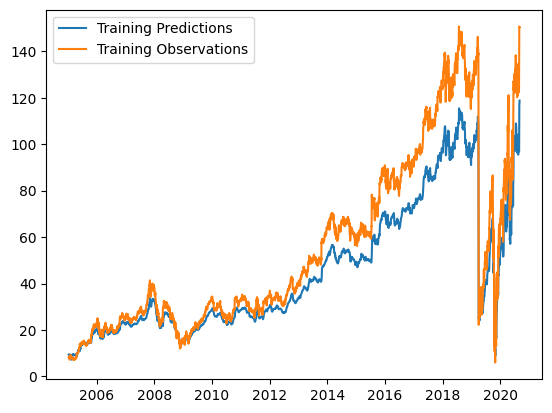

In [246]:
# plotting the training
train_predictions = regressor_best.predict(Big_X_train)
train_predictions_unscaled = scaler_pred.inverse_transform(train_predictions)

Big_y_train_unscale = scaler_pred.inverse_transform(Big_y_train.reshape(-1,1))

window_size = 100
plt.plot(data_big_training [window_size:].index, train_predictions_unscaled)
plt.plot(data_big_training [window_size:].index, Big_y_train_unscale)
plt.legend(['Training Predictions', 'Training Observations'])


12/12 [==============================] - 1s 58ms/step


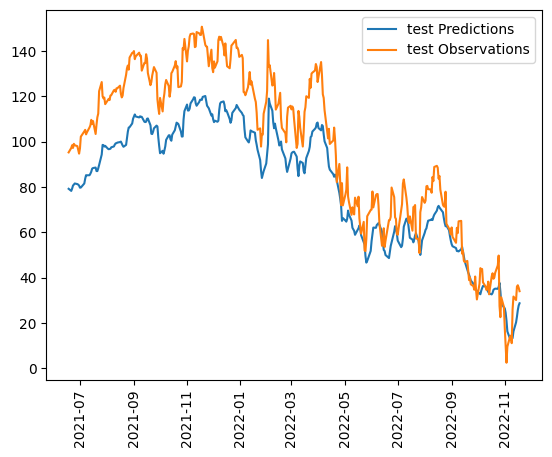

In [210]:
# plotting the test
y_pred_unscaled = regressor_best.predict(X_test_100)
y_pred = scaler_pred.inverse_transform(y_pred_unscaled)
# y_test_ten
y_test_100_unscaled = scaler_pred.inverse_transform(y_test_100.reshape(-1,1))
window_size =100 
plt.plot(data_test[window_size:].index, y_pred) # prediction
plt.plot(data_test[window_size:].index, y_test_100_unscaled) # actual
plt.xticks(rotation = 90)

plt.legend(['test Predictions', 'test Observations'])

In [195]:
y_test_ten

array([0.30773294, 0.31656226, 0.31694169, 0.32305597, 0.33628888,
       0.34105682, 0.33279285, 0.32084679, 0.29387531, 0.2983234 ,
       0.31640608, 0.26894185, 0.27303297, 0.30624528, 0.30202772,
       0.26548304, 0.28213004, 0.32635123, 0.26359371, 0.28481536,
       0.28654851, 0.33098535, 0.29167352, 0.29507286, 0.31443491,
       0.31336382, 0.27255684, 0.27774893, 0.27431974, 0.28500877,
       0.27913238, 0.27861175, 0.27205846, 0.28723281, 0.28692782,
       0.2966647 , 0.34807864, 0.41338754, 0.41279258, 0.43133641,
       0.44305932, 0.45826329, 0.43513743, 0.44442054, 0.43517455,
       0.46628187, 0.46710009, 0.47055154, 0.46402809, 0.46377509,
       0.44490405, 0.48014698, 0.48865647, 0.47406245, 0.52820631,
       0.5653833 , 0.5506776 , 0.53955727, 0.50911949, 0.51097159,
       0.52927741, 0.54217562, 0.49975455, 0.47528236, 0.42345175,
       0.4404782 , 0.48078668, 0.48469189, 0.47131766, 0.47524512,
       0.51048808, 0.5023133 , 0.54811147, 0.54989661, 0.56809

In [196]:
get_MAE(X_test_ten,y_test_ten,regressor_best)

15/15 [==============================] - 0s 2ms/step
Mean Square Error (MSE): 23.52
Mean Absolute Error (MAE): 21.32
Mean Absolute Percentage Error (MAPE): 24.75 %
Median Absolute Percentage Error (MDAPE): 23.74 %
450


True

In [ ]:
# The date from which on the date is displayed
display_start_date = "2004-08-19" 

# Add the difference between the valid and predicted prices
train = pd.DataFrame(data['Close'][window_size:training_size +1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data['Close'][window_size+training_size: validation_size]).rename(columns={'Close': 'y_test'})

# validation_size

valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# # Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel("Google", fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()